In [2]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
from glob import glob
os.chdir('./drive/MyDrive/THESIS_AQUAPONDS/ROI/')
os.cwd()

'/content/drive/MyDrive/THESIS_AQUAPONDS/ROI'

## Prepare ROI for processing

In [7]:
# Install packages
#!pip install shapely
#!pip install geopandas
import shapely as shp
import geopandas as gpd

In [16]:
# Load ROI
roi_path = glob(os.path.join(os.getcwd(), '*'))
vnm = gpd.read_file(roi_path[0])
type(vnm)

geopandas.geodataframe.GeoDataFrame

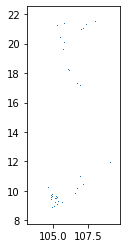

In [17]:
vnm.plot()

In [26]:
vnm_geom = vnm['geometry']
type(vnm_geom[0][0])

shapely.geometry.polygon.Polygon

In [35]:
geomSize = [len(l) for l in vnm_geom]
geomSize_not1 = [i for i, k in enumerate(vnm_geom) if len(k)!=1]
geomSize_not1

[242]

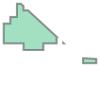

In [41]:
vnm_geom[242]

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=pMkfv_uS-98xYYmB_4XolmwLzzkuVaH2ZflL-dpiM0Y&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhdQs0hwa5goCiggxATVfGbTaROv95cWhJp5sGNEaPKNZ8eC_e4qR0

Successfully saved authorization token.


In [ ]:
# Define Study Area
roi = ee.Geometry.Polygon(
        [[[118.42839284489463, 38.2990090127178],
          [118.42839284489463, 36.871290789300936],
          [119.51603932926963, 36.871290789300936],
          [119.51603932926963, 38.2990090127178]]], None, False)
print(roi.getInfo())

{'geodesic': False, 'type': 'Polygon', 'coordinates': [[[118.42839284489463, 36.871290789300936], [119.51603932926963, 36.871290789300936], [119.51603932926963, 38.2990090127178], [118.42839284489463, 38.2990090127178], [118.42839284489463, 36.871290789300936]]]}


In [ ]:
# Load Satellitie Archive
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('1999', '2020') \
      .filterBounds(roi).sort("system:time_start", True)
ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
      .filterDate('1984', '2013') \
      .filterBounds(roi).sort("system:time_start", True)
ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
      .filterDate('1984', '1994') \
      .filterBounds(roi).sort("system:time_start", True)

ls_all = ls7.merge(ls5).merge(ls4) \
        .sort('system:time_start', True)
print(ls_all.size().getInfo())

5225


In [ ]:
# Function to Mask Clouds
def maskCloud(image):
  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [ ]:
# Function for Smoothing
def smooth(image):
  kernel = ee.Kernel.square(radius = 7, units = 'pixels', normalize = True)
  return image.convolve(kernel)

In [ ]:
ls_all = ls_all.map(maskCloud).map(smooth)
print(ls_all.size().getInfo())

5225


* Reduce ImageCollection, Group by YEAR

In [ ]:
years = ee.List.sequence(1984, 2019)
ls_Treduced = ee.ImageCollection.fromImages(
    years.map(lambda YEAR: ls_all.filter(ee.Filter.calendarRange(YEAR, YEAR, 'year')) \
              .mean().clip(roi).set({'year': YEAR, 'system:time_start': ee.Date.fromYMD(YEAR, 12, 31)}))
)
print(ls_Treduced.size().getInfo())

36


* Water Mask with Otsu's Method

In [ ]:
# Function of ostu's method
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    def iFunc(i):
      aCounts = counts.slice(0, 0, i) 
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)) \
            .add(bCount.multiply(bMean.subtract(mean).pow(2)))

    # Compute between sum of squares, where each mean partitions the data
    bss = indices.map(iFunc)

    return means.sort(bss).get([-1])

In [ ]:
# Function of Otsu's Method
def thresholding(image):

  #Compute the histogram of the NIR band. (the mean adn variance are only FYI)
  histogram = image.select(['B4']).reduceRegion(
      reducer = ee.Reducer.histogram(255,2).combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      bestEffort = True)
  
  threshold = otsu(histogram.get('B4_histogram'))
  water = image.select(['B4']).lt(threshold)
  return water.rename(['watermask']) \
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

In [ ]:
ls_wmsk = ls_Treduced.map(thresholding)
print(ls_wmsk.size().getInfo())

36


* Yearly Step (Iteration)

In [ ]:
# Function to have difference between two years
def annual_diff(list):
  diff = ee.Image(ee.List(list).get(1)).subtract(
      ee.Image(ee.List(list).get(0))
  )
  return diff.set({'year': ee.Image(ee.List(list).get(1)).get('year'),
                   'system:time_start': ee.Image(ee.List(list).get(1)).get('system:time_start')})

In [ ]:
list_wmsk = ls_wmsk.toList(ls_wmsk.size())

# Calculate "Backward Gradient", i.e. (Tn+1 - Tn)
ls_grad = list_wmsk.slice(0) \
          .zip(list_wmsk.slice(1)) \
          .map(annual_diff)

ls_84 = ee.List([ls_wmsk.first()])

list_footprint = ls_84.cat(ls_grad)  
ls_footprint = ee.ImageCollection.fromImages(list_footprint)        
print(ls_footprint.size().getInfo())

36


* Remap

In [ ]:
# Function for remapping
def remap_gain(image):
  gain = image.eq(1).selfMask()
  return gain.remap([1], ee.List([image.get('year')])) \
             .rename('gain_year') \
             .copyProperties(image)

In [ ]:
# Function for unite pixel type
def unipt(image):
  return image.cast({'gain_year': ee.PixelType('int', 1984, 2019)})             

In [ ]:
# Remap value "1" (ponds gain) to "year" of that gain
ls_gain = ls_footprint.select(['watermask']).map(remap_gain).map(unipt)
print(ls_gain.size().getInfo())

36


* Mosaic 

In [ ]:
fpGain = ls_gain.mosaic().cast({'gain_year': ee.PixelType('int', 1984, 2019)})
print(fpGain.getInfo())

{'type': 'Image', 'bands': [{'id': 'gain_year', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 1984, 'max': 2019}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


In [ ]:
# Function to Visualize
import folium

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
print('Folium version: ' + folium.__version__)


# Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

Folium version: 0.8.3


In [ ]:
fpGain_id = fpGain.getMapId({'min': 1984, 'max': 2019, 
                             'palette': ['#ebf5fb', '#d6eaf8', '#aed6f1', '#85c1e9', '#5dade2', '#3498db', '#2e86c1', '#2874a6', '#21618c', '#1b4f72']})
center = [37.18, 118.8]
Mapdisplay(center, {'Footprint Gain': fpGain_id}, zoom_start = 7)